In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip -q uninstall -y protobuf
!pip -q install "protobuf==3.20.3"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires p

In [10]:
!pip -q install roboflow


# AgriVision: Automated Multi-Class Fruit Classification and Quality Control System

**Project:** Deep Transfer Learning for Fruit Classification  
**Dataset:** Roboflow - Fruit Classification Dataset (10 classes)  
**Model:** MobileNetV2 with Transfer Learning  
**Author:** [Your Name]

## Project Overview

This project focuses on modernizing agricultural supply chains by developing a robust Computer Vision system capable of identifying distinct fruit varieties. By leveraging Transfer Learning using MobileNetV2 architecture, we build a scalable, high-accuracy model to automate manual sorting processes, reducing waste and increasing efficiency in food processing lines.

## Dataset Information

- **Source:** [Roboflow - Fruit Classification](https://universe.roboflow.com/nunnapas/fruit-rzujm)
- **Classes:** 10 types of fruits (Apple, Avocado, Banana, Cherry, Kiwi, Mango, Orange, Pineapple, Strawberries, Watermelon)
- **Structure:** train/, valid/, test/ directories with class subfolders


In [11]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix


In [12]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("ROBOFLOW_API_KEY")

print(ROBOFLOW_API_KEY[:6], "OK")


7I0D9f OK


In [13]:
from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("nunnapas").project("fruit-rzujm")
dataset = project.version(1).download("folder")  # downloads to /kaggle/working/...

DATASET_DIR = dataset.location  # e.g. /kaggle/working/Fruit-1
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

print("Dataset:", DATASET_DIR)
print("Train:", TRAIN_DIR)
print("Valid:", VALID_DIR)
print("Test :", TEST_DIR)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fruit-1 in folder:: 100%|██████████| 1409/1409 [00:00<00:00, 5625.35it/s]

Dataset: /kaggle/working/Fruit-1
Train: /kaggle/working/Fruit-1/train
Valid: /kaggle/working/Fruit-1/valid
Test : /kaggle/working/Fruit-1/test



## PHASE 1 (EDA + Preprocessing + Augmentation)

### EDA: Identify classes (list subfolders in train)

In [14]:
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
NUM_CLASSES = len(class_names)

print("Classes found:", class_names)
print("Num classes:", NUM_CLASSES)


Classes found: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Num classes: 10


### EDA: Show 1 sample image per class

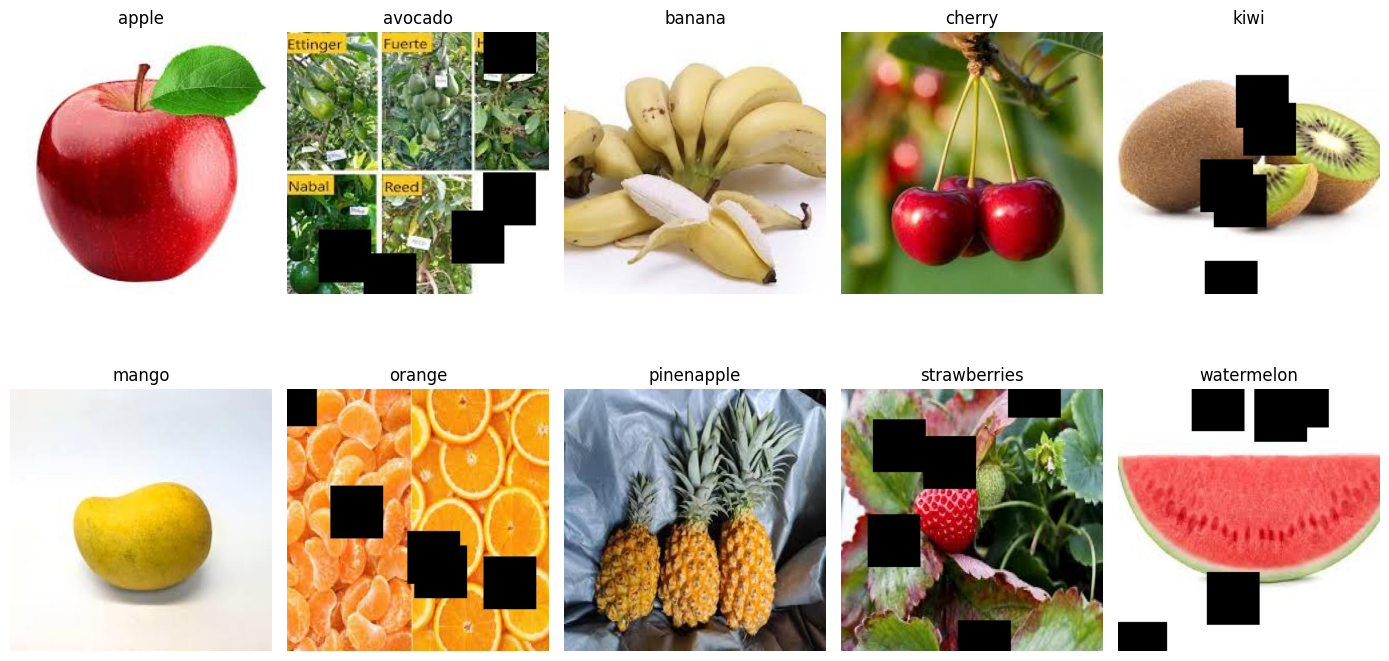

In [15]:
from PIL import Image

plt.figure(figsize=(14, 8))

for i, cls in enumerate(class_names):
    cls_folder = os.path.join(TRAIN_DIR, cls)
    imgs = glob.glob(os.path.join(cls_folder, "*.jpg")) + glob.glob(os.path.join(cls_folder, "*.png")) + glob.glob(os.path.join(cls_folder, "*.jpeg"))
    img_path = random.choice(imgs)

    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)  # 10 classes
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


### EDA: Distribution plot (bar chart images per class in train)

,class,count
8,strawberries,115
2,banana,114
1,avocado,112
4,kiwi,112
7,pinenapple,112
6,orange,111
9,watermelon,101
3,cherry,100
5,mango,100
0,apple,90


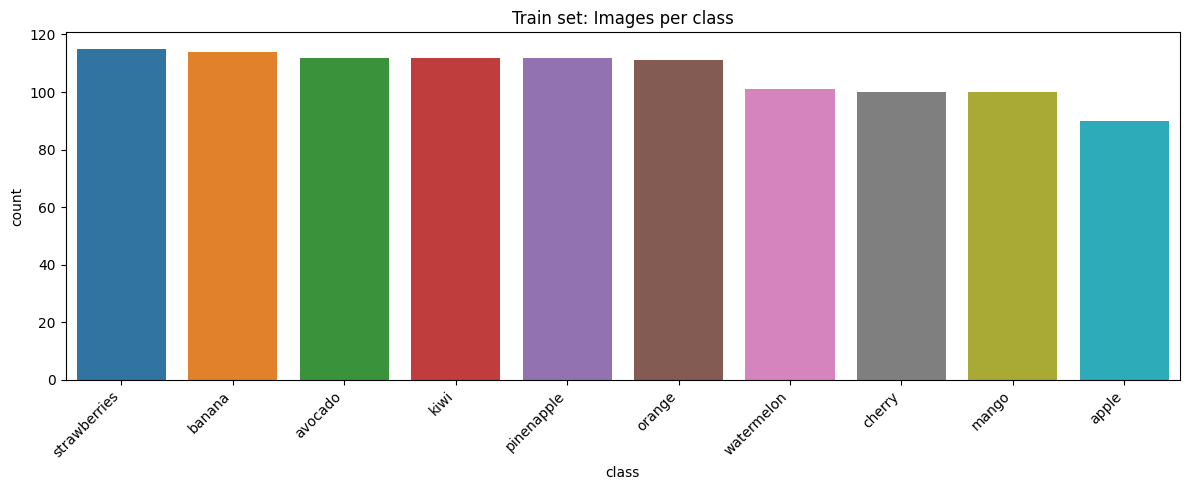

In [16]:
counts = []
for cls in class_names:
    cls_folder = os.path.join(TRAIN_DIR, cls)
    n = len(glob.glob(os.path.join(cls_folder, "*.jpg"))) + len(glob.glob(os.path.join(cls_folder, "*.png"))) + len(glob.glob(os.path.join(cls_folder, "*.jpeg")))
    counts.append(n)

df_counts = pd.DataFrame({"class": class_names, "count": counts}).sort_values("count", ascending=False)
display(df_counts)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_counts, x="class", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Train set: Images per class")
plt.tight_layout()
plt.show()


### Preprocessing + Augmentation setup (Resize + Normalize + Augment only train)

In [17]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

valid_test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

valid_gen = valid_test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = valid_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nClass indices:", train_gen.class_indices)


Found 1067 images belonging to 10 classes.
Found 205 images belonging to 10 classes.
Found 102 images belonging to 10 classes.

Class indices: {'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}


## PHASE 2 (Transfer Learning)

### Build Transfer Learning model (MobileNetV2)

In [18]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # freeze for feature extraction

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()


2026-01-06 19:33:54.487884: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile + Callbacks (Adam + CategoricalCrossentropy + EarlyStopping)

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_fruit_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

callbacks = [early_stop, checkpoint, reduce_lr]


### Train model

In [20]:
EPOCHS = 15

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3489 - loss: 2.0776 - val_accuracy: 0.8049 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7863 - loss: 0.6488 - val_accuracy: 0.8195 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8296 - loss: 0.4792 - val_accuracy: 0.8537 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9032 - loss: 0.3465 - val_accuracy: 0.8488 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9286 - loss: 0.2594 - val_accuracy: 0.8439 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9301 - loss: 0.2196 - val_accuracy: 0.8537 - val_loss: 0.3974 - learning_rate: 0.0010
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9282 - loss: 0.2137 - val_accuracy: 

## PHASE 3 (Optional Fine-Tuning)

### Fine-tune (unfreeze top layers + low LR)

In [21]:
# Unfreeze some top layers for fine-tuning
base_model.trainable = True

# Freeze early layers, unfreeze later layers
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

FINE_TUNE_EPOCHS = 8
total_epochs = len(history.history["loss"]) + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_gen,
    epochs=total_epochs,
    initial_epoch=len(history.history["loss"]),
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)


Epoch 12/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8468 - loss: 0.4789 - val_accuracy: 0.8488 - val_loss: 0.3953 - learning_rate: 1.0000e-05
Epoch 13/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8579 - loss: 0.4442 - val_accuracy: 0.8634 - val_loss: 0.3929 - learning_rate: 1.0000e-05
Epoch 14/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8891 - loss: 0.3491 - val_accuracy: 0.8585 - val_loss: 0.3923 - learning_rate: 1.0000e-05
Epoch 15/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8911 - loss: 0.3473 - val_accuracy: 0.8537 - val_loss: 0.3973 - learning_rate: 1.0000e-05
Epoch 16/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9137 - loss: 0.2938 - val_accuracy: 0.8488 - val_loss: 0.3997 - learning_rate: 1.0000e-05
Epoch 17/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9005 - loss: 0.2817 - val_accuracy: 0.8537 - val_loss: 0.3977 - learning_rate: 2.0000e-06
Epoch 18/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9126 

## PHASE 4 (Evaluation & Analysis)

### Evaluate on TEST set (final test accuracy)

In [22]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\nTEST LOSS: {test_loss:.4f}")
print(f"TEST ACC : {test_acc:.4f} ({test_acc*100:.2f}%)")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.8711 - loss: 0.4480

TEST LOSS: 0.4571
TEST ACC : 0.8627 (86.27%)


### Classification report (Precision/Recall/F1 per class)

In [23]:
test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

# Ensure class order matches generator indexing
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
ordered_class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print(classification_report(y_true, y_pred, target_names=ordered_class_names, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  
              precision    recall  f1-score   support

       apple     0.9000    0.8182    0.8571        11
     avocado     0.8571    1.0000    0.9231        12
      banana     1.0000    0.9167    0.9565        12
      cherry     1.0000    1.0000    1.0000         6
        kiwi     0.7500    0.7500    0.7500         8
       mango     0.6667    0.8889    0.7619         9
      orange     0.8750    0.6364    0.7368        11
  pinenapple     0.8182    0.9000    0.8571        10
strawberries     0.8000    1.0000    0.8889         8
  watermelon     1.0000    0.8000    0.8889        15

    accuracy                         0.8627       102
   macro avg     0.8667    0.8710    0.8620       102
weighted avg     0.8764    0.8627    0.8624       102



### Training curves (Accuracy & Loss)

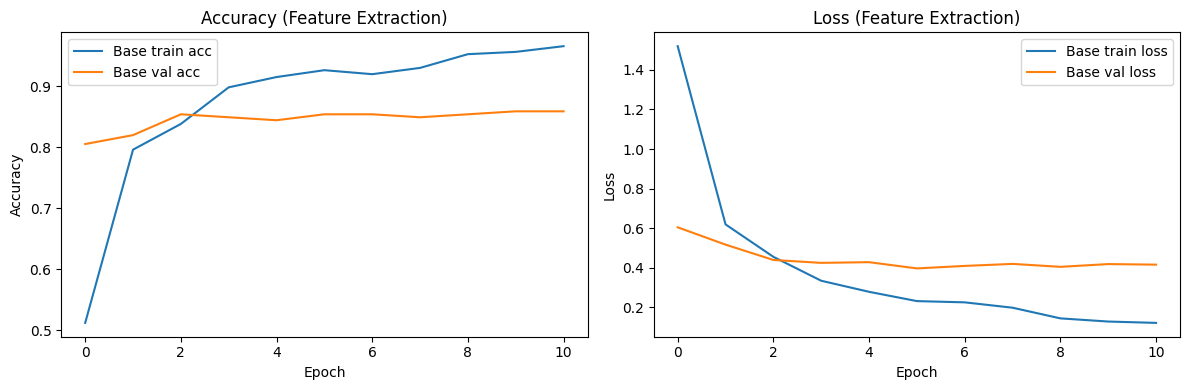

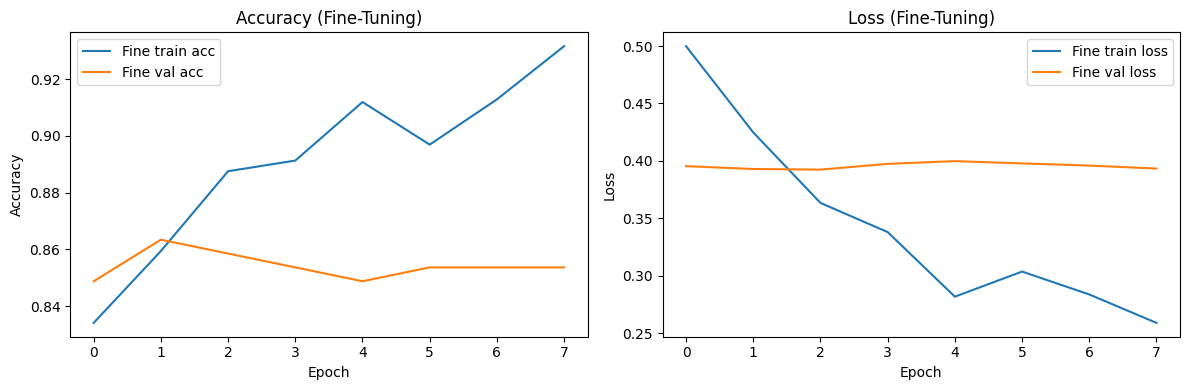

In [24]:
def plot_history(histories, title_suffix=""):
    # histories = list of (label, history_dict)
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for label, h in histories:
        plt.plot(h["accuracy"], label=f"{label} train acc")
        plt.plot(h["val_accuracy"], label=f"{label} val acc")
    plt.title("Accuracy " + title_suffix)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for label, h in histories:
        plt.plot(h["loss"], label=f"{label} train loss")
        plt.plot(h["val_loss"], label=f"{label} val loss")
    plt.title("Loss " + title_suffix)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

histories = [("Base", history.history)]
if "history_fine" in globals():
    # Merge plots by using only fine history alone can be confusing; plot separately:
    plot_history([("Base", history.history)], "(Feature Extraction)")
    plot_history([("Fine", history_fine.history)], "(Fine-Tuning)")
else:
    plot_history(histories)


### Confusion matrix (heatmap)

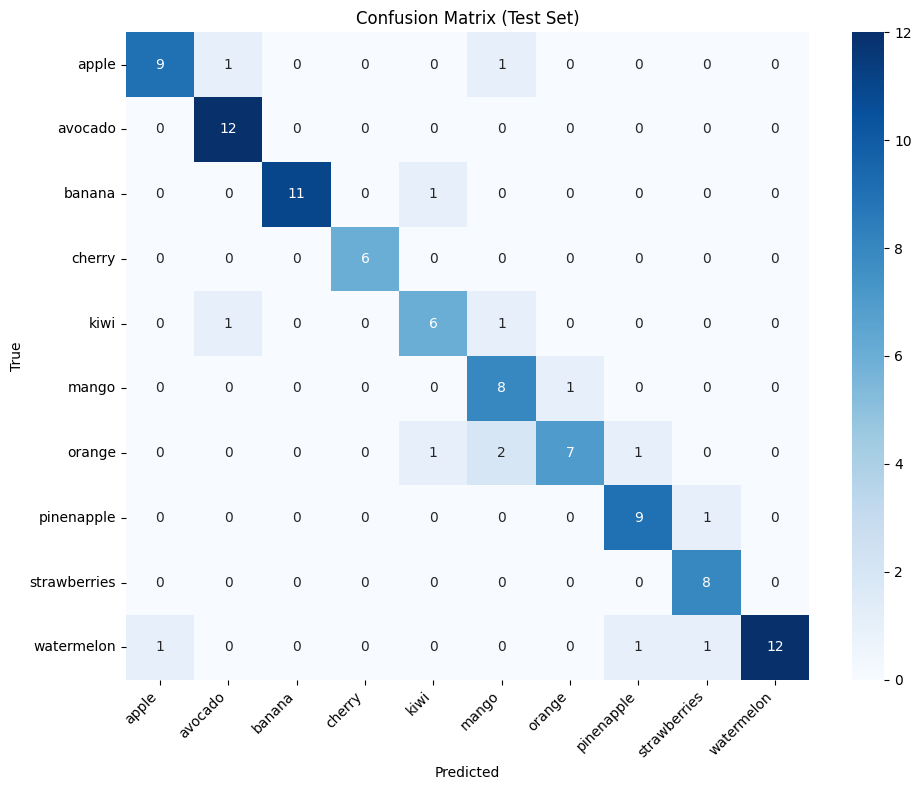

In [25]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=ordered_class_names,
            yticklabels=ordered_class_names,
            cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Error analysis: show 5 misclassified test images + comments

Misclassified count: 14


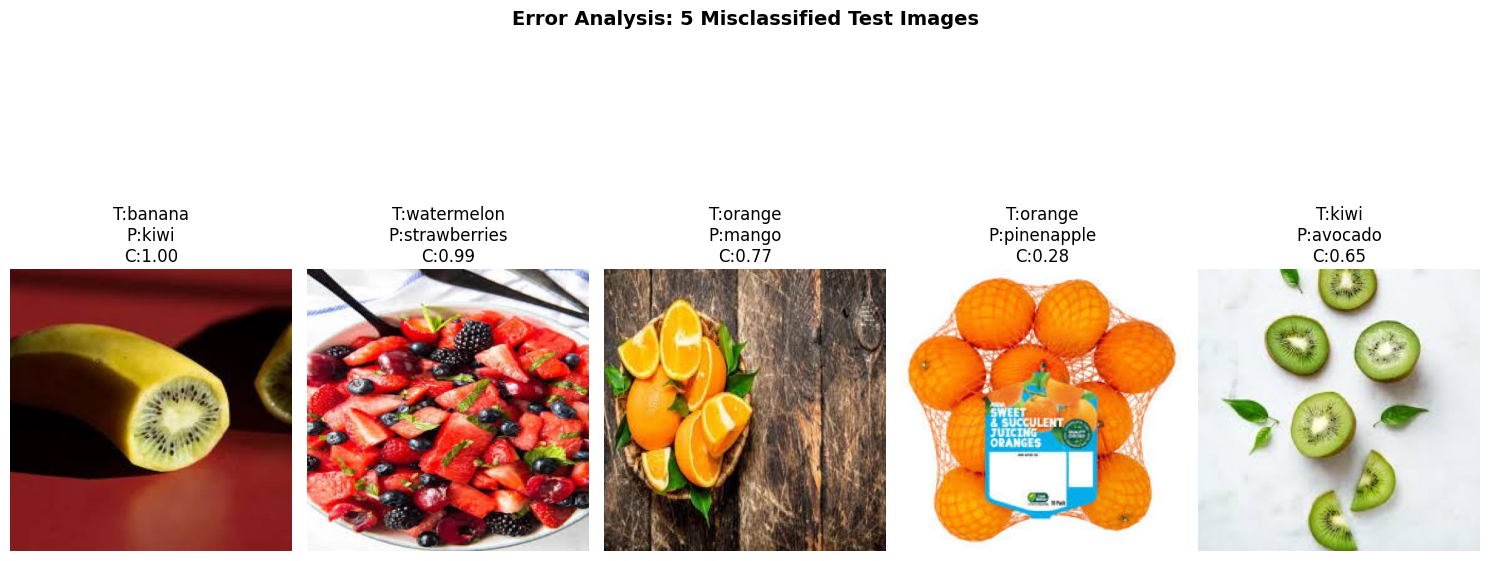


ERROR ANALYSIS COMMENTS:
- True: banana | Pred: kiwi | Conf: 1.00 -> Likely confusion due to similar color/texture or background noise.
- True: watermelon | Pred: strawberries | Conf: 0.99 -> Likely confusion due to similar color/texture or background noise.
- True: orange | Pred: mango | Conf: 0.77 -> Similar warm colors; shape differences may be less visible depending on angle.
- True: orange | Pred: pinenapple | Conf: 0.28 -> Likely confusion due to similar color/texture or background noise.
- True: kiwi | Pred: avocado | Conf: 0.65 -> Both are green; texture/lighting and partial views can confuse the model.


In [26]:
import matplotlib.image as mpimg

mis_idx = np.where(y_pred != y_true)[0]
print("Misclassified count:", len(mis_idx))

if len(mis_idx) == 0:
    print("No misclassifications found!")
else:
    show_n = min(5, len(mis_idx))
    chosen = np.random.choice(mis_idx, size=show_n, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(chosen):
        img_rel_path = test_gen.filepaths[idx]
        img = mpimg.imread(img_rel_path)

        true_label = ordered_class_names[y_true[idx]]
        pred_label = ordered_class_names[y_pred[idx]]
        confidence = np.max(y_prob[idx])

        plt.subplot(1, show_n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{true_label}\nP:{pred_label}\nC:{confidence:.2f}")

    plt.suptitle("Error Analysis: 5 Misclassified Test Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Simple textual comments (you can customize these)
    print("\nERROR ANALYSIS COMMENTS:")
    for idx in chosen:
        true_label = ordered_class_names[y_true[idx]]
        pred_label = ordered_class_names[y_pred[idx]]
        confidence = np.max(y_prob[idx])

        comment = "Likely confusion due to similar color/texture or background noise."
        if ("apple" in true_label.lower() and "cherry" in pred_label.lower()) or ("cherry" in true_label.lower() and "apple" in pred_label.lower()):
            comment = "Both are red and can look similar at small size; lighting may cause confusion."
        elif ("orange" in true_label.lower() and "mango" in pred_label.lower()) or ("mango" in true_label.lower() and "orange" in pred_label.lower()):
            comment = "Similar warm colors; shape differences may be less visible depending on angle."
        elif ("kiwi" in true_label.lower() and "avocado" in pred_label.lower()) or ("avocado" in true_label.lower() and "kiwi" in pred_label.lower()):
            comment = "Both are green; texture/lighting and partial views can confuse the model."

        print(f"- True: {true_label} | Pred: {pred_label} | Conf: {confidence:.2f} -> {comment}")


## PHASE 5 (Deployment / Inference)

### Deployment function: predict_fruit(image_path)

In [36]:
from tensorflow.keras.preprocessing import image as kimage

def predict_fruit(image_path):
    """
    Predict fruit class from a local image path.

    Prints:
      - Predicted class
      - Confidence score

    Returns:
      (predicted_class, confidence)
    """
    img = kimage.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = kimage.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    confidence = float(probs[pred_idx])
    pred_class = ordered_class_names[pred_idx]

    print("PREDICTION RESULT")
    print("-" * 40)
    print("Image:", image_path)
    print("Predicted class:", pred_class)
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print("-" * 40)

    return pred_class, confidence


### Test predict_fruit() on one test image

In [30]:
# Pick one test image
sample_test_images = glob.glob(os.path.join(TEST_DIR, "**", "*.jpg"), recursive=True)
if len(sample_test_images) == 0:
    sample_test_images = glob.glob(os.path.join(TEST_DIR, "**", "*.png"), recursive=True)

sample_path = random.choice(sample_test_images)
predict_fruit(sample_path)


PREDICTION RESULT
----------------------------------------
Image: /kaggle/working/Fruit-1/test/cherry/img_411_jpeg.rf.b41212d48a46e070d60bc7779d158ecd.jpg
Predicted class: cherry
Confidence: 0.9999 (99.99%)
----------------------------------------


('cherry', 0.9999443292617798)